In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np


In [2]:
folder_path_1 = '/Volumes/CYQ_HD/程业勤/11_IPP_PhD/M1/S3/250331/20250331 Si hem with Iris data/normed'


In [3]:
def extract_angle(filename):
    # Look for the last number at the end of the filename, even if there's no extension
    match = re.search(r"(\d+(?:\.\d+)?)\s*(?=\s*$|\.\w+$)", filename)
    return float(match.group(1)) if match else None

In [4]:
def extract_data_from_single_file(file_path):
    try:
        # Try reading with different encodings
        df = pd.read_csv(file_path, sep='\s+', header=None, names=['wavenumber', 'Normed R'], encoding='ISO-8859-1')
        return df
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

In [5]:
# Function to iterate through the folder and extract data for different angles
def read_dpt_files_in_folder(folder_path):
    data = {}
    for file in os.listdir(folder_path):
        angle = extract_angle(file)
        if angle is not None:
            # Construct the full file path
            file_path = os.path.join(folder_path, file)
            # Extract data from the file
            df = extract_data_from_single_file(file_path)
            if df is not None:
                data[angle] = df
        
            
            
    return data

In [6]:
data_normed = read_dpt_files_in_folder(folder_path_1)

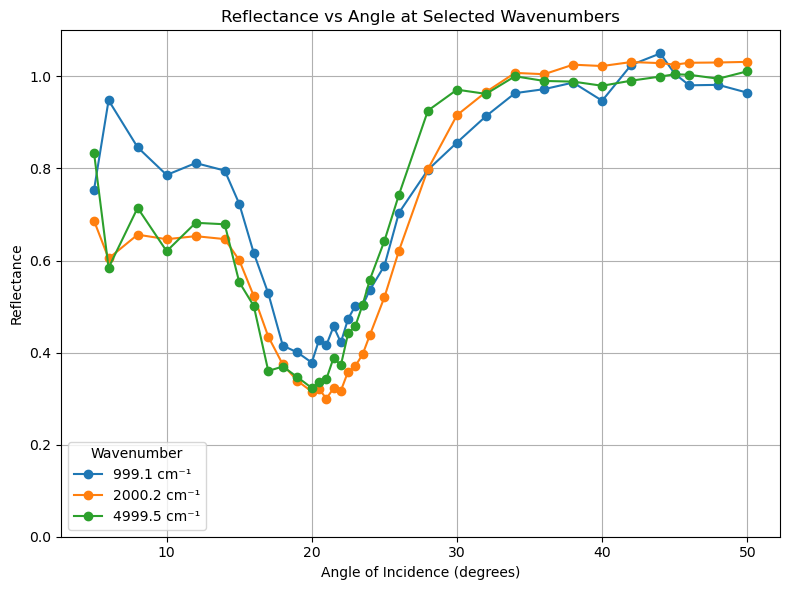

In [7]:
# --- SELECT wavenumbers to plot (will match to nearest available) ---
selected_wavenumbers = [1000, 2000, 5000]  # or any wavenumbers you want

# --- Sorted angle list from the dictionary ---
angles = sorted(data_normed.keys())

# --- Get available wavenumbers from any sample DataFrame ---
sample_df = next(iter(data_normed.values()))
available_wavenumbers = sample_df["wavenumber"].values

# --- Match to nearest available wavenumber ---
rounded_wavenumbers = [
    available_wavenumbers[np.argmin(np.abs(available_wavenumbers - wn))]
    for wn in selected_wavenumbers
]

# --- Plot reflectance vs angle for each wavenumber ---
plt.figure(figsize=(8, 6))

for wn in rounded_wavenumbers:
    reflectances = []
    for angle in angles:
        df = data_normed[angle]
        matched_row = df[np.isclose(df["wavenumber"], wn)]
        if not matched_row.empty:
            reflectances.append(matched_row["Normed R"].values[0])
        else:
            reflectances.append(np.nan)  # or 0, depending on preference

    plt.plot(angles, reflectances, marker='o', linestyle='-', label=f'{wn:.1f} cm⁻¹')

plt.title("Reflectance vs Angle at Selected Wavenumbers")
plt.xlabel("Angle of Incidence (degrees)")
plt.ylabel("Reflectance")
plt.ylim(0, 1.1)
plt.grid(True)
plt.legend(title="Wavenumber")
plt.tight_layout()
plt.show()


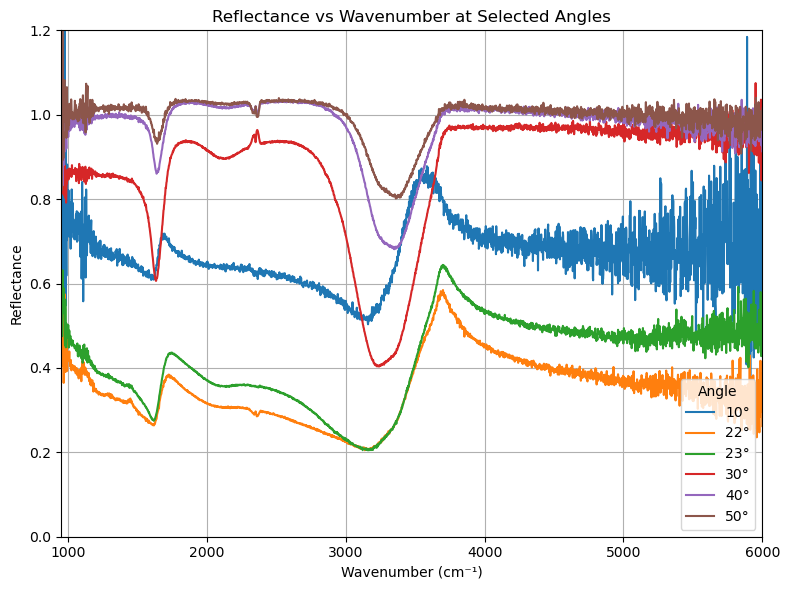

In [8]:
# --- SELECT angles
selected_angles = [10, 22, 23,30,40, 50]  # Update this list as you wish


# --- Plot reflectance vs wavenumber for selected angles ---
plt.figure(figsize=(8, 6))

for angle in selected_angles:
    if angle not in data_normed:
        print(f"Warning: angle {angle}° not found in data_normed.")
        continue

    df = data_normed[angle]
    wavenumbers = df["wavenumber"].values
    reflectance = df["Normed R"].values
    plt.plot(wavenumbers, reflectance, label=f"{angle}°")

plt.title("Reflectance vs Wavenumber at Selected Angles")
plt.xlabel("Wavenumber (cm⁻¹)")
plt.ylabel("Reflectance")
plt.xlim(950, 6000)
plt.ylim(0, 1.2)
plt.grid(True)
plt.legend(title="Angle")
plt.tight_layout()
plt.show()


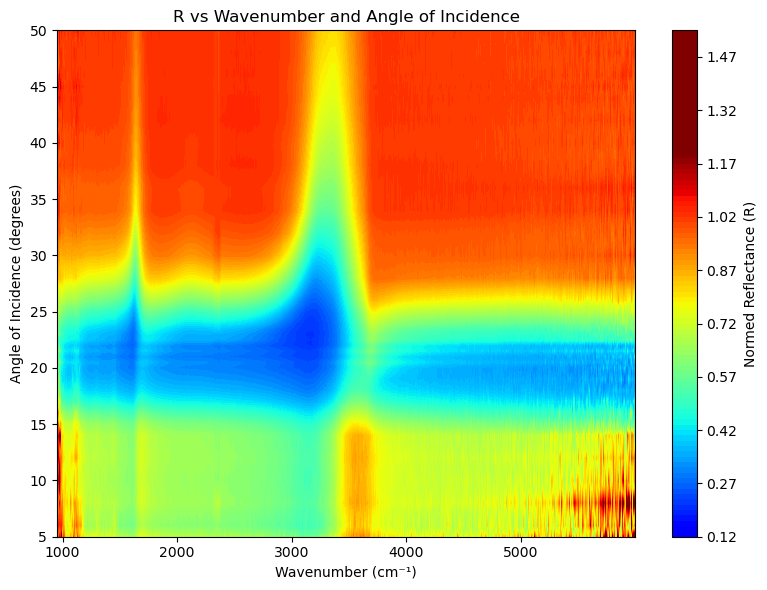

In [9]:
# --- Get sorted list of angles ---
angles = sorted(data_normed.keys())

# --- Extract wavenumbers from one sample DataFrame ---
sample_df = next(iter(data_normed.values()))
wavenumbers = sample_df['wavenumber'].values

# --- Optional: clip wavenumber range ---
wmin, wmax = 950, 6000
mask = (wavenumbers >= wmin) & (wavenumbers <= wmax)
wavenumbers_clipped = wavenumbers[mask]

# --- Build 2D array for Normed R ---
R_matrix = np.array([
    data_normed[angle]['Normed R'].values[mask]
    for angle in angles
])

# --- Meshgrid for contour plotting ---
W_grid, A_grid = np.meshgrid(wavenumbers_clipped, angles)

# --- Plot contour ---
plt.figure(figsize=(8, 6))
contour = plt.contourf(W_grid, A_grid, R_matrix, levels=100, cmap='jet', vmin=0, vmax=1.2)
plt.colorbar(contour, label='Normed Reflectance (R)')
plt.title('R vs Wavenumber and Angle of Incidence')
plt.xlabel('Wavenumber (cm⁻¹)')
plt.ylabel('Angle of Incidence (degrees)')
plt.tight_layout()
plt.show()
